# NNの計算結果検討

In [80]:
#import
import sys
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. 各種関数

### ANN定義

In [68]:
def data_shaping_ANN(input_signal, signal, max_tap, tap):
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y


class Dataset_ANN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)


class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    if type(tmp) is np.float64:
        evm = np.sqrt(tmp / len(y_pred))
    else:
        evm = torch.sqrt(tmp / len(y_pred))
    return evm

### CVNN定義

In [69]:
def data_shaping_CVNN(input_signal, signal, max_tap, tap):
    x = np.zeros((len(input_signal) - (max_tap - 1), tap, 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, :, 0] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, :, 1] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y


class Dataset_CVNN(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        
        x_i = x[:, 0]
        x_q = x[:, 1]
        y_i = y[0]
        y_q = y[1]
        return x_i, x_q, y_i, y_q

    
class ZReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        for i in range(x_i.shape[0]):
            for j in range(x_i.shape[1]):
                if x_i[i, j] < 0 or x_q[i, j] < 0:
                    x_i[i, j] = 0
                    x_q[i, j] = 0
        return x_i, x_q


class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = F.relu(x_i), F.relu(x_q)
        return x_i, x_q


class modReLU(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.b = torch.tensor(-math.sqrt(1 / in_features), requires_grad=True)
    
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        norm = torch.sqrt(x_i ** 2 + x_q ** 2)
        
        out_i = F.relu(norm + self.b) * x_i / norm
        out_q = F.relu(norm + self.b) * x_q / norm
        return out_i, out_q


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 重み定義 Xavierの初期値
        k = 1 / in_features
        weight_i = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_i = nn.Parameter(weight_i)
        weight_q = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_q = nn.Parameter(weight_q)
        
        bias_i = torch.empty(out_features).uniform_(-k, k)
        self.bias_i = nn.Parameter(bias_i)
        bias_q = torch.empty(out_features).uniform_(-k, k)
        self.bias_q = nn.Parameter(bias_q)
        
    def forward(self, x_i, x_q):
        i = nn.functional.linear(x_i, self.weight_i) - nn.functional.linear(x_q, self.weight_q) + self.bias_i
        q = nn.functional.linear(x_i, self.weight_q) + nn.functional.linear(x_q, self.weight_i) + self.bias_q
        return i, q


class CVNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super().__init__()
        self.fc1 = ComplexLinear(input_dim, hidden_neuron)
        self.fc2 = ComplexLinear(hidden_neuron, output_dim)
        if activation == 'ZReLU':
            self.activation = ZReLU()
        elif activation == 'CReLU':
            self.activation = CReLU()
        elif activation == 'modReLU':
            self.activation = modReLU(input_dim)
    
    def forward(self, x_i, x_q):
        x_i, x_q = self.fc1(x_i, x_q)
        x_i, x_q = self.activation(x_i, x_q)
        x_i, x_q = self.fc2(x_i, x_q)
        return x_i, x_q


"""def evm_score_CVNN(x_i, x_q, y_i, y_q):
    tmp = 0
    for i in range(len(x_i)):
        tmp += ((x_i[i] - y_i[i]) ** 2 + (x_q[i] - y_q[i]) ** 2) / (y_i[i] ** 2 + y_q[i] ** 2)
    evm = torch.sqrt(tmp / len(x_i))
    return evm""";

### データ読み込み

In [101]:
def prepare_input(signal_info, form, PdBm, Lmax):
    max_tap = 501
    
    # t_condition 伝送条件
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    signal_type = signal_info['signal_type']
    if signal_type == 'prbs':
        N = signal_info['N']  # PRBSの次数
        itr = signal_info['itr']  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = signal_info['seed']  # 乱数シード
        bit_num = signal_info['bit_num']  # ビット長を指定
    elif signal_type == 'image':
        target_dir = signal_info['target_dir']
        step = signal_info['step']  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = signal_info['image_number']
        image_number_split = image_number.split(', ')
        ebtb = signal_info['ebtb']  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvの列指定に用いる文字列
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition = 'N=='+str(N)+'&itr=='+str(itr)
    elif signal_type == 'random':
        condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    elif signal_type == 'image':
        condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=='+image_number_split[0]+'&ebtb=='+str(ebtb)

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition + '&' + t_condition)

    # 伝送信号を入力データに整形する
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        sys.exit()
    sgnl = load_pickle(t_query.iloc[0]['data_path'])
    lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
    x, y = data_shaping(sgnl.signal['x_0'][n//2::n], lc[n//2::n], max_tap, tap)
    
    if signal_type == 'image' and len(image_number_split) > 1:
        for i in range(1, len(image_number_split)):
            condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb)
            t_query = t_df.query(condition + '&' + t_condition)
            if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                print('指定された伝送条件の信号が存在しません')
                sys.exit()
            sgnl = load_pickle(t_query.iloc[0]['data_path'])
            lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
            x_tmp, y_tmp = data_shaping(sgnl.signal['x_0'][n//2::n], lc[n//2::n], max_tap, tap)
            x = np.concatenate([x, x_tmp])
            y = np.concatenate([y, y_tmp])
    return x, y

### Model読み込み

In [78]:
def prepare_model(model_type, tap, batch_size, neuron, epochs, lr, activation, signal_info, form, PdBm, Lmax):
    device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
    # print('Device available now:', device)

    # l_condition 学習条件
    max_tap = 501

    # t_condition 伝送条件
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか
    signal_type = signal_info['signal_type']
    if signal_type == 'prbs':
        N = signal_info['N']  # PRBSの次数
        itr = signal_info['itr']  # PRBSの繰り返し回数
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)
    elif signal_type == 'random':
        seed = signal_info['seed']  # 乱数シード
        bit_num = signal_info['bit_num']  # ビット長を指定
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)
    elif signal_type == 'image':
        target_dir = signal_info['target_dir']
        step = signal_info['step']  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = signal_info['image_number']
        ebtb = signal_info['ebtb']  # 8B10Bを行うか
        x, y = prepare_input(signal_info=signal_info, form=form, PdBm=PdBm, Lmax=Lmax)

    # csvの列指定に用いる文字列
    l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition = 'N=='+str(N)+'&itr=='+str(itr)
    elif signal_type == 'random':
        condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    elif signal_type == 'image':
        condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)

    # csvをpandasで読み込む
    l_df_dir = '../data/params/' + model_type + '.csv'
    l_df = pd.read_csv(l_df_dir, index_col=0)

    # csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

    if len(l_query) == 0 or l_query['epochs'].max() < epochs:
        print('指定された条件の学習結果は存在しません')
    else:
        index = l_query[l_query['epochs']==epochs].index
        if model_type == 'ANN':
            model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
        elif model_type == 'CVNN':
            model = CVNN(input_dim=tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index].values[0]))

    mean = np.mean(x)
    std = np.std(x)
    return model, mean, std

### 予測

In [72]:
def predict_ANN(tap, batch_size, neuron, epochs, lr, activation, signal_info_model, signal_info_input, form, PdBm, Lmax):
    model, mean, std = prepare_model(model_type='ANN', tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, activation=activation, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
    
    x, y = prepare_input(signal_info=signal_info_input, form=form, PdBm=PdBm, Lmax=Lmax)
    dataset = Dataset_ANN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    nnc = np.empty((0, 2), float)
    y = np.empty((0, 2), float)
    for x_bat, y_bat in dataloader:
        out = model(x_bat)
        nnc = np.append(nnc, out.detach().numpy().reshape(-1, 2) * std + mean, axis=0)
        y = np.append(y, (y_bat.detach().numpy().reshape(-1, 2) * std + mean).astype(np.int32), axis=0)
    
    #evm = round(evm_score_ANN(nnc, y) * 100, 2)
    return nnc, y

In [96]:
def predict_CVNN(tap, batch_size, neuron, epochs, lr, activation, signal_info_model, signal_info_input, form, PdBm, Lmax):
    model, mean, std = prepare_model(model_type='CVNN', tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, activation=activation, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
    
    x, y = prepare_input(signal_info=signal_info_input, form=form, PdBm=PdBm, Lmax=Lmax)
    dataset = Dataset_CVNN(x=x, y=y, mean=mean, std=std)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    nnc_i = np.empty(0, float)
    nnc_q = np.empty(0, float)
    y_i = np.empty(0, float)
    y_q = np.empty(0, float)
    for x_bat_i, x_bat_q, y_bat_i, y_bat_q in dataloader:
        out_i, out_q = model(x_bat_i, x_bat_q)
        nnc_i = np.append(nnc_i, out_i.detach().numpy() * std + mean)
        nnc_q = np.append(nnc_q, out_q.detach().numpy() * std + mean)
        y_i = np.append(y_i, (y_bat_i.detach().numpy() * std + mean).astype(np.int32))
        y_q = np.append(y_q, (y_bat_q.detach().numpy() * std + mean).astype(np.int32))
    
    nnc = np.hstack([nnc_i.reshape(-1, 1), nnc_q.reshape(-1, 1)])
    y = np.hstack([y_i.reshape(-1, 1), y_q.reshape(-1, 1)])
    return nnc, y

# 2. 可視化

## 2.1 コンスタレーション

In [74]:
def display_constellation(nnc, y):
    evm = round(evm_score(nnc, y) * 100, 2)
    nnc = nnc[:, 0] + nnc[:, 1] * 1j
    y = y[:, 0] + y[:, 1] * 1j
    
    symbol, inverse, counts = np.unique(y, return_inverse=True, return_counts=True)
    cm = plt.get_cmap('rainbow', 16)
    boxdic = {
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1}
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    for i in range(len(symbol)):
        ax.plot(nnc[y == symbol[i]].real, nnc[y == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
    for i in range(len(symbol)):
        ax.plot(y[y == symbol[i]].real, y[y == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
    ax.text(-100000, 95000, 'EVM: ' + str(evm) + '%', color='black', fontsize=20, bbox=boxdic)
    ax.set_xlim((-110000, 110000))
    ax.set_ylim((-110000, 110000))
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    plt.tick_params(labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)

In [102]:
tap = 1
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
activation = 'ReLU'
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

#signal_info_input = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
#signal_info_input = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_input = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}

nnc, y = predict_ANN(tap, batch_size, neuron, epochs, lr, activation, signal_info_model, signal_info_input, form, PdBm, Lmax)
display_constellation(nnc, y)

指定された伝送条件の信号が存在しません


SystemExit: 

d:\pycharmprojects\masterthesis\venv\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 2.2 重み

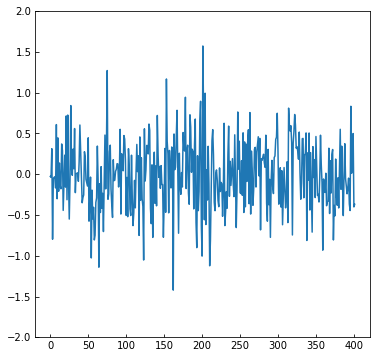

In [193]:
tap = 201
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

#signal_info_model = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
#signal_info_model = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
#signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_model = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

model, mean, std = prepare_model(tap=tap, batch_size=batch_size, neuron=neuron, epochs=epochs, lr=lr, signal_info=signal_info_model, form=form, PdBm=PdBm, Lmax=Lmax)
weight = model.state_dict()['fc1.weight'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
for i in [7]:#, 25, 60, 98, 140, 160, 179, 226, 250, 289]:
    ax.plot(weight[i])
ax.set_ylim((-2, 2))
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')

## 2.3 入力シンボル数(tap)依存性

In [132]:
batch_size = 100
neuron = 300
epochs = 500
lr = 0.001
form = 'RZ16QAM'
PdBm = 1
Lmax = 2500

signal_info_model_prbs0 = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
signal_info_model_prbs1 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_model_random = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_model_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_model_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

signal_info_input_prbs0 = {'signal_type': 'prbs', 'N': 13, 'itr': 1}
signal_info_input_prbs1 = {'signal_type': 'prbs', 'N': 17, 'itr': 1}
signal_info_input_random = {'signal_type': 'random', 'seed': 1234, 'bit_num': 100000}
signal_info_input_image0 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0', 'ebtb': True}
signal_info_input_image1 = {'signal_type': 'image', 'target_dir': 'train_0', 'step': 10, 'image_number': '0, 1, 2, 3, 4, 5, 6, 7, 8, 9', 'ebtb': True}

### 2.3.1 ANN trained on PRBS13

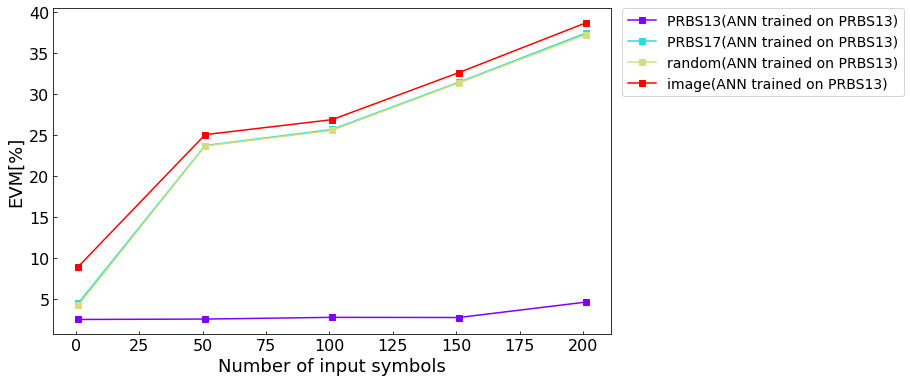

In [151]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((4, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    evms[0, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs0, signal_info_input_prbs0, form, PdBm, Lmax)
    evms[1, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs0, signal_info_input_prbs1, form, PdBm, Lmax)
    evms[2, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs0, signal_info_input_random, form, PdBm, Lmax)
    evms[3, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs0, signal_info_input_image0, form, PdBm, Lmax)

cm = plt.get_cmap('rainbow', 4)
legend = ['PRBS13', 'PRBS17', 'random', 'image']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(4):
    ax.plot(taps, evms[i], '-s', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legend[i]+'(ANN trained on PRBS13)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### 2.3.2 ANN trained on PRBS17

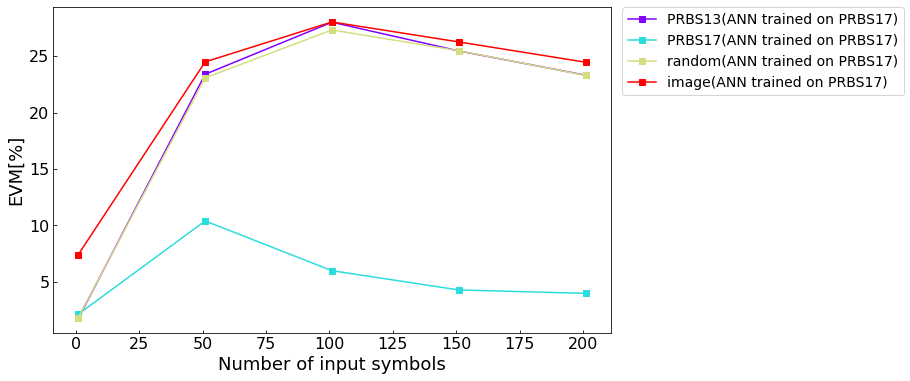

In [152]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((4, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    evms[0, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs1, signal_info_input_prbs0, form, PdBm, Lmax)
    evms[1, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs1, signal_info_input_prbs1, form, PdBm, Lmax)
    evms[2, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs1, signal_info_input_random, form, PdBm, Lmax)
    evms[3, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_prbs1, signal_info_input_image0, form, PdBm, Lmax)

cm = plt.get_cmap('rainbow', 4)
legend = ['PRBS13', 'PRBS17', 'random', 'image']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(4):
    ax.plot(taps, evms[i], '-s', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legend[i]+'(ANN trained on PRBS17)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### 2.3.3 ANN trained on Random

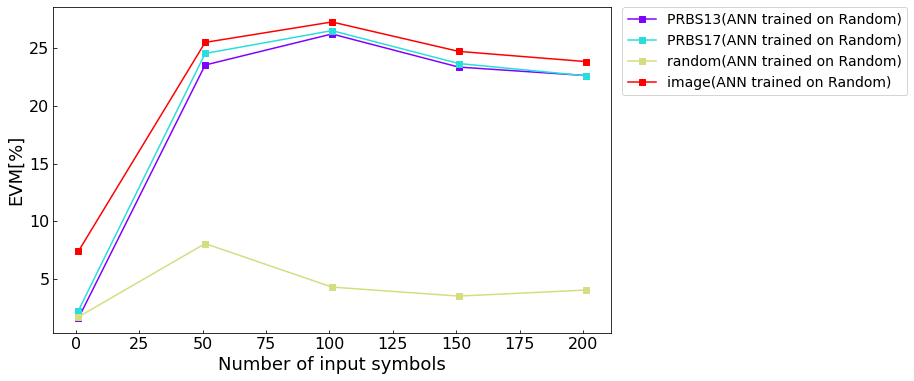

In [195]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((4, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    evms[0, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_random, signal_info_input_prbs0, form, PdBm, Lmax)
    evms[1, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_random, signal_info_input_prbs1, form, PdBm, Lmax)
    evms[2, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_random, signal_info_input_random, form, PdBm, Lmax)
    evms[3, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_random, signal_info_input_image0, form, PdBm, Lmax)

cm = plt.get_cmap('rainbow', 4)
legend = ['PRBS13', 'PRBS17', 'random', 'image']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(4):
    ax.plot(taps, evms[i], '-s', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legend[i]+'(ANN trained on Random)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### 2.3.4 ANN trained on Image(1)

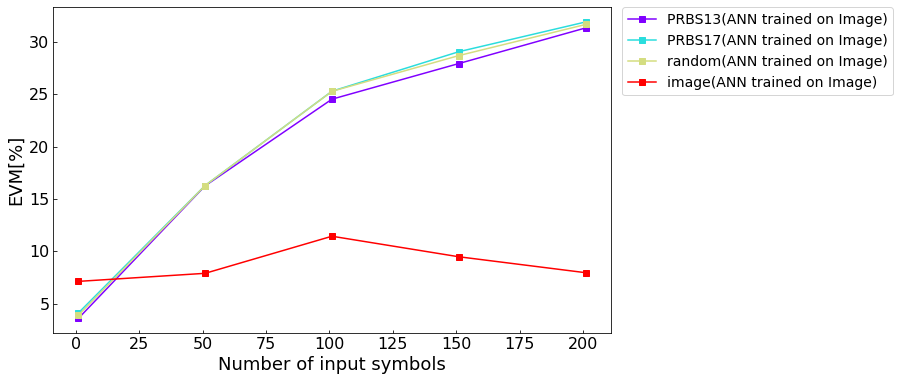

In [154]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((4, 5), dtype=float)
for i, tap in enumerate(tqdm(taps)):
    evms[0, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image0, signal_info_input_prbs0, form, PdBm, Lmax)
    evms[1, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image0, signal_info_input_prbs1, form, PdBm, Lmax)
    evms[2, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image0, signal_info_input_random, form, PdBm, Lmax)
    evms[3, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image0, signal_info_input_image0, form, PdBm, Lmax)

cm = plt.get_cmap('rainbow', 4)
legend = ['PRBS13', 'PRBS17', 'random', 'image']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(4):
    ax.plot(taps, evms[i], '-s', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legend[i]+'(ANN trained on Image)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

### 2.3.5 ANN trained on Image(10)

In [155]:
taps = [1, 51, 101, 151, 201]
evms = np.zeros((4, 5), dtype=float)
for i, taps in enumerate(tqdm(taps)):
    evms[0, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image1, signal_info_input_prbs0, form, PdBm, Lmax)
    evms[1, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image1, signal_info_input_prbs1, form, PdBm, Lmax)
    evms[2, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image1, signal_info_input_random, form, PdBm, Lmax)
    evms[3, i] = predict(tap, batch_size, neuron, epochs, lr, signal_info_model_image1, signal_info_input_image, form, PdBm, Lmax)

cm = plt.get_cmap('rainbow', 4)
legend = ['PRBS13', 'PRBS17', 'random', 'image']
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
for i in range(4):
    ax.plot(taps, evms[i], '-s', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=legend[i]+'(ANN trained on Image)')
plt.legend(fontsize=14, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Number of input symbols', fontsize=18)
plt.ylabel('EVM[%]', fontsize=18)
#ax.set_xlim((-110000, 110000))
#ax.set_ylim((-110000, 110000))
ax.xaxis.set_tick_params(labelsize= 16, direction='in')
ax.yaxis.set_tick_params(labelsize= 16, direction='in')

NotImplementedError: cannot evaluate scalar only bool ops

In [47]:
l_df = pd.read_csv(l_df_dir, index_col=0)
for i in range(len(l_df)):
    t = l_df.iloc[i]['image_number']
    t2 = ''
    for j in range(1, len(t), 3):
        if j == 1:
            t2 = t2 + t[j]
        else:
            t2 = t2 + ', ' + t[j]
        l_df['image_number'].loc[i] = t2
print(l_df['image_number'])
l_df.to_csv(l_df_dir)

0       0
1       0
2    0, 1
3    0, 1
Name: image_number, dtype: object
